### REINFORCE with Baseline

Here we are implementing REINFORCE algorithm for policy improvement. Unlike Q learning, the agent does not select the best action based on state-action values but rather from a probability distribution of actions. REINFORCE is based on policy gradient theorem and uses gradient ascent to update the policy parameters.

#### We are running the algorithm on Cart Pole domain using Open AI gym and have used whitened rewards as the baseline.

In [58]:
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

import numpy as np
from tqdm import notebook

# device for CUDA 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [59]:
# discount factor
gamma = 0.99

num_episodes = 1000

# iterations per episode
iterations = 10000

# Policy NN hidden size
policy_hidden_size = 128

# State Value NN hidden size
sv_hidden_size = 128

In [60]:
# Small Neural Network to learn the policy paramerters

class PolicyNN(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space, hidden_size=128):
        super(PolicyNN, self).__init__()
        self.input = nn.Linear(observation_space, hidden_size)
        self.output = nn.Linear(hidden_size, action_space)
    
    #forward pass
    def forward(self, x):
        # input states
        x = self.input(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output(x)
        
        #get softmax for a probability distribution
        action_probabilities = F.softmax(actions, dim=1)
        
        return action_probabilities

In [61]:
# Small Neural Network to learn state value function
class StateValueNN(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space, hidden_size=128):
        super(StateValueNN, self).__init__()
        
        self.input = nn.Linear(observation_space, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
    
    # forward pass    
    def forward(self, x):
        # input layer
        x = self.input(x)
        
        # relu activation
        x = F.relu(x)
        
        # state value output
        state_value = self.output(x)
        
        return state_value

In [62]:
def get_action(model, state):
    ''' Selects an action given current state
    Args:
    - model [Neural Network]: NN to process state
    - state [Array]: Array of action space in an environment
    
    Return:
    - [int]: selected action
    - [float]: log probability of selecting the action
    '''
    
    # convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    state = state.detach()
    # use network to predict action probabilities
    action_probs = model(state)
    
    # sample an action from action probabilities
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [63]:
def get_discounted_rewards(rewards,gamma):
    ''' Get cumulated discounted reward from a list of rewards
    Args:
    - rewards [List]: list of rewards for an episode
    
    Returns:
    - G [List]: list of cumulative discounted rewards
    '''
    # Calculate G at time t
    G = []
    
    # cumulative reward
    cum_r = 0
    
    # iterate rewards from Gt to G0
    for r in rewards[::-1]:
        # calculate cumulative reward
        cum_r = r + cum_r * gamma
        
        #add to front of G
        G.insert(0, cum_r)
    
    G = torch.tensor(G).to(device)
    # normalizing rewards
    G = (G - G.mean())/G.std()
    
    return G

In [64]:
def train_policy_NN(delta_list, log_probs, optimizer):
    ''' Update policy parameters
    
    Args:
    - deltas [List]: difference between predicted and actual state values (G - V(s))
    - log_probs [List]: trajectory of log probabilities of action taken
    - optimizer [Optimizer]: optimizer to update policy parameters
    
    Returns:
    - None
    '''
    
    # policy loss
    policy_loss = []
    
    for delta, log_p in zip(delta_list, log_probs):
        # negative sign for gradient ascent
        policy_loss.append(-delta * log_p)
    
    # Backpropagating the policy loss
    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()

In [65]:
def train_value_NN(G, state_values, optimizer):
    ''' Update state-value function parameters
    Args:
    - G [List]: trajectory of cumulative discounted rewards 
    - state_vals [List]: trajectory of predicted state-value at each step
    - optimizer [Optimizer]: optimizer to update state-value network parameters
    '''
    
    # MSE loss
    MSE = F.mse_loss(state_values, G)
        
    #Backpropagate
    optimizer.zero_grad()
    MSE.backward()
    optimizer.step()

In [51]:
def reinforceBaseline(train_score,num_episodes,iterations,env,model_policy,model_value,optimizer_policy,optimizer_value,gamma):
    ''' Reinforce algorithm with baseline
    Args:
    - train_score [float]: score of the training episode
    - num_episodes [int]: number of episodes to train
    - iterations [int]: number of iterations per episode
    - env [gym environment]: environment to train on
    - model_policy [Neural Network]: NN for policy learning
    - model_value [Neural Network]: NN for state value function learning
    - optimizer_policy [Optimizer]: optimizer for policy NN
    - optimizer_value [Optimizer]: optimizer for state value NN
    - gamma [float]: discount factor

    Returns:
    - None
    '''
    # Main loop
    scores = []

    # using deque to store recent scores
    recent_scores = deque(maxlen=100)

    for episode in notebook.tqdm(range(num_episodes)):
        
        # initialization
        state = env.reset()
        trajectory = []
        score = 0
        
        # iterate for each step
        for step in range(iterations):
            #env.render()
            
            # get next action and log probability
            action, log_prob = get_action(model_policy, state)
            
            # execute
            new_state, reward, done, info = env.step(action)
            
            # adding up score for current episode
            score += reward
            
            # recording the trajectory
            trajectory.append([state, action, reward, log_prob])
            
            # break if done
            if done:
                break
            
            state = new_state
        
        # scores for plotting
        scores.append(score)
        recent_scores.append(score)
        
        # breaking if average score is greater than or equal to a given solved score (training completed)
        if len(recent_scores) == 100:
            average = sum(recent_scores)/len(recent_scores)
            if average >= train_score:
                break
        
        
        # get state, action, reward, log probability from trajectory
        states, actions, rewards, log_probs = map(list, zip(*trajectory))
        
        # get discounted rewards
        G = get_discounted_rewards(rewards,gamma)
        
        # get state values from model and train state value network
        state_vals = []
        for state in states:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            state_vals.append(model_value(state))
            
        state_vals = torch.stack(state_vals).squeeze()
        
        train_value_NN(G, state_vals, optimizer_value)
            
        # list of delta values (G - V(s))
        delta_list = [G_t - S_val for G_t, S_val in zip(G, state_vals)]
        delta_list = torch.tensor(delta_list).to(device)
        
        train_policy_NN(delta_list, log_probs, optimizer_policy)
        
    env.close()
    return scores

### Cartpole-v1 using REINFORCE with whitened rewards as a baseline

In [66]:
# Environment
environment_name = "CartPole-v1"
env = gym.make(environment_name)

# Policy Neural Network
model_policy = PolicyNN(env.observation_space.shape[0], env.action_space.n,policy_hidden_size).to(device)
model_value = StateValueNN(env.observation_space.shape[0],sv_hidden_size).to(device)

# Adam optimizer
# learning rate for plicy parameters is 1e-3 and learning rate for state value parameters is 1e-2
policy_lr = 1e-3
value_lr = 1e-2
optimizer_policy = optim.Adam(model_policy.parameters(), lr=policy_lr)
optimizer_value = optim.Adam(model_value.parameters(), lr=value_lr)

In [ ]:
cart_pole_train_score = 195
scores = reinforceBaseline(cart_pole_train_score,num_episodes,iterations,env,model_policy,model_value,optimizer_policy,optimizer_value,gamma)

### Plotting the Loss

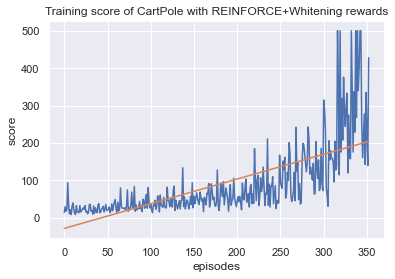

In [52]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('no. of episodes')
plt.title('CartPole with REINFORCE + Whitening rewards baseline')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

### Testing Policy

In [56]:
done = False
state = env.reset()

scores = []

for i in notebook.tqdm(range(100)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action, lp = get_action(model_policy, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)

In [57]:
# average score
sum(scores)/len(scores)

249.38